# Deep Learning per la Segmentazione di Noduli Polmonari: Analisi del Dataset [LIDC-IDRI](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966254)

---

<br />
<img src="../images/lung_scan.png" height=800 width=1400>
<br />

## Il Progetto

Lo scopo di questo progetto è utilizzare modelli di Deep Learning per la segmentazione di noduli polmonari maligni all'interno di immagini TAC (Tomografia Assiale Computerizzata) del torace. 

Il dataset utilizzato è il [LIDC-IDRI](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966254)(Lung Image Database Consortium and Image Database Resource Initiative) che contiene 1018 casi di immagini TAC del torace e i file XML associati che registrano i risultati di un processo di annotazione dell'immagine a due fasi eseguito da quattro radiologi esperti del torace.

Nel primo passaggio, ogni radiologo ha esaminato indipendentemente ogni scansione TAC e ha contrassegnato le lesioni appartenenti a una delle tre categorie ("nodulo > o =3 mm," "nodulo <3 mm," e "non-nodulo > o =3 mm").

Nel secondo passaggio, ogni radiologo ha esaminato i propri contrassegni insieme ai contrassegni anonimizzati degli altri tre radiologi per fornire un'opinione finale.

<br />

## Descrizione del Dataset

Il dataset è composto da 1018 casi di immagini TAC del torace e i file XML associati, ma dato che le immagini TAC sono in formato .dcm (Digital Imaging and Communications in Medicine) si è deciso di utilizzare pylidc (Python package for parsing and processing the LIDC-IDRI dataset) per convertire le immagini in formato .png e creare le maschere associate.

Grazie a questo processo Il dataset risultante è composto da 1018 cartelle rappresentanti i pazienti, ognuna delle quali contiene due cartelle: 'images' che contiene le scansioni TAC in formato .png e 'masks' che contiene le maschere associate alle immagini TAC in formato .png.

Sia le immagini che le maschere hanno dimensioni 512 x 512 pixel e come unico canale la scala di grigi. 

Per la selezione e la classificazione delle immagini si è utilizzato l'attributo 'Malignancy' presente nei file XML che consentiva di classificare le immagini in base alla malignità del nodulo polmonare. Per questo motivo i pixel classificati sono stati divisi in **Maligni** e **Benigni** attraverso il valore di 'Malignancy' con una soglia maggiore uguale a 3.

Per la creazione delle maschere si è utilizzata una maschera vuota di 0 dove successivamente sono stati classificati i pixel contenuti nella regione di interesse con i valori 1 e 2 rispettivamente per i noduli maligni e benigni.

In [1]:
from keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, add, UpSampling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TerminateOnNaN
from keras.models import Sequential
from tensorflow.data import Dataset
from keras.activations import relu
from keras.metrics import F1Score
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import albumentations as Alb
import keras.utils as utils
import tensorflow as tf
from PIL import Image
import numpy as np
import pickle
import random
import keras
import cv2
import os

from libraries.Image_augmentation import Image_augmentation

# Exploratory Data Analysis

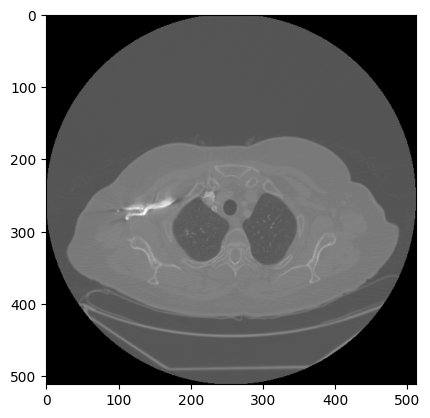

In [22]:
# Esempio Immagine dimensioni 512 x 512 in scala di grigi
img = Image.open('../resources/training/0001/images/86.png').convert('L')
plt.imshow(img, cmap='gray')

In [3]:
# Valori dei pixel dell'immagine
val_img = np.unique(img)
val_img

array([  0,  51,  52,  54,  55,  56,  58,  59,  60,  62,  63,  64,  65,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,  95,
        96,  97,  99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110,
       111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 214, 216, 217, 219, 221, 222, 223, 224, 225, 227,
       229, 230, 232, 233, 234, 235, 236, 237, 239, 240, 241, 242, 243,
       245, 250, 251, 252, 255], dtype=uint8)

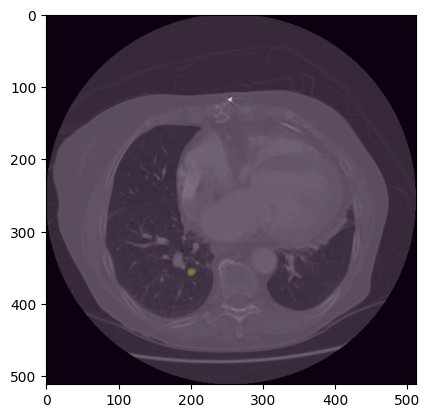

In [21]:
# Esempio di immagine con maschera dimensioni 512 x 512 in scala di grigi
mask = Image.open('../resources/training/0001/masks/86.png').convert('L')
plt.imshow(img, cmap='gray')
plt.imshow(mask, alpha=0.2)

# Classi presenti nelle maschere

1. **Background**: pixel_value = 0

2. **Malignant Tissue**: pixel_value = 1

3. **Benign Tissue**: pixel_value = 2

In [5]:
num_classes = np.unique(mask)
num_classes

array([0, 1], dtype=uint8)

In [27]:
class_counts = np.zeros(3)

In [28]:
for patient in [patient for patient in os.listdir(f'../resources/training')]:
        masks_dir = f'../resources/training/{patient}/masks'
        for filepath in [file for file in os.listdir(masks_dir)]:
                mask = Image.open(f'../resources/training/{patient}/masks/{filepath}').convert('L')
                mask = np.array(mask)
                res = np.bincount(mask.flatten(), minlength=3)
                class_counts += res

In [29]:
class_counts

array([3.00847193e+09, 1.96473500e+06, 5.49320000e+05])

In [32]:
total = np.sum(class_counts)
total

3010985984.0

In [34]:
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, class_counts[2], 100 * class_counts[2] / total))

Examples:
    Total: 3010985984.0
    Positive: 549320.0 (0.02% of total)

Examples:
    Total: 3010985984.0
    Positive: 1964735.0 (0.07% of total)

Examples:
    Total: 3010985984.0
    Positive: 3008471929.0 (99.92% of total)


In [ ]:
weight_for_0 = (1 / class_counts[0]) * (total / 2.0)
weight_for_1 = (1 / class_counts[1]) * (total / 2.0)
weight_for_2 = (1 / class_counts[2]) * (total / 2.0)

In [ ]:
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
# Calculated class weights {0: 0.5004178292268188, 1: 766.2575319317873, 2: 2740.648423505425}
class_weight

# Image Augmentation

Per aumentare la quantità di dati a disposizione per l'addestramento della rete neurale, si è deciso di utilizzare la libreria **Albumentations** per effettuare delle modifiche alle immagini e alle maschere.


#### Modifiche effettuate:

1. **Resize**: Modificare le dimensioni riducendole a 256 x 256
2. **Rotate**: Ruotare l'immagine di un angolo compreso tra 1 e 359 gradi
3. **Horizontal Flip**: Riflettere l'immagine orizzontalmente
4. **Random Brightness and Contrast**: Modificare il contrasto e la luminosità dell'immagine


In [14]:
image_augmentation = Alb.Compose(
    [
        Alb.Resize(256, 256),
        Alb.Rotate((1, 359), border_mode=cv2.BORDER_CONSTANT, value=0),
        Alb.HorizontalFlip(p=0.5),
        Alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), contrast_limit=(-0.2, 0.3)),
    ]
)

In [15]:
# Esempio di immagine modificata
result = image_augmentation(image=np.array(img), mask=np.array(mask))
aug_img = result['image']
aug_mask = result['mask']

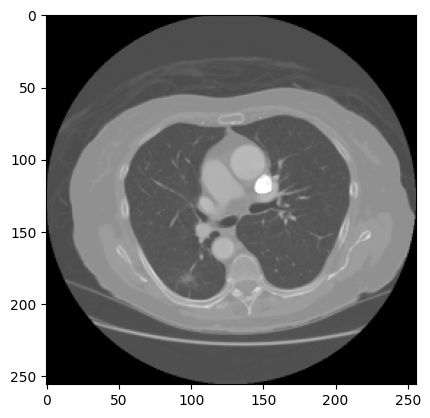

In [16]:
plt.imshow(aug_img, cmap='gray')

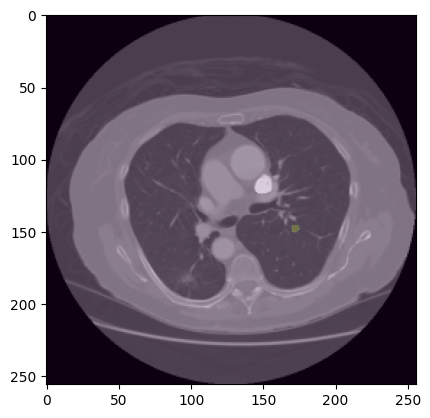

In [17]:
plt.imshow(aug_img, cmap='gray')
plt.imshow(aug_mask, alpha=0.2)

# Extract of the dataset

Per utilizzare le immagini create dai file .dcm si è deciso di utilizzare un generatore in quanto avendo grandi quantità di dati non è possibile caricarli tutti in memoria.

Il generatore utilizzato scorre tutti i **pazienti** presenti del trainset ed estra le immagini e le maschere associate. Successivamente le i due file passano attraverso la funzione di image augmentation e vengono convertiti in tensori.

Infine si utilizza **'Dataset from generator'** che permette di creare un oggetto dataset a partire dal generatore stesso.

In [18]:
def image_generator(split: str = 'training'):
    patients = os.listdir(f'../resources/{split}')
    random.shuffle(patients)  # Shuffle the list of patients

    for patient in patients:
        img_dir = f'../resources/{split}/{patient}/images'
        if os.path.exists(img_dir):
            for file in os.listdir(img_dir):
                img = np.array(Image.open(f'../resources/{split}/{patient}/images/{file}').convert('L'))
                mask = np.array(Image.open(f'../resources/{split}/{patient}/masks/{file}').convert('L'))

                aug_img, aug_mask = Image_augmentation(image=img, mask=mask)

                yield aug_img, aug_mask

In [19]:
train_dataset = Dataset.from_generator(
    lambda: image_generator('training'),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
    )
)

2023-10-16 12:47:44.149647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20609 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2023-10-16 12:47:44.152121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20609 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9
2023-10-16 12:47:44.154055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 20609 MB memory:  -> device: 2, name: NVIDIA L4, pci bus id: 0000:00:05.0, compute capability: 8.9
2023-10-16 12:47:44.156376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 20609 MB memory:  -> device: 3, name: NVIDIA L4, pci bus id: 0000:00:06.0, compute capability: 8.9


In [20]:
val_dataset = Dataset.from_generator(
    lambda: image_generator('validation'),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
    )
)

In [21]:
train_dataset = train_dataset.shuffle(buffer_size=10_000).batch(64)
val_dataset = val_dataset.shuffle(buffer_size=10_000).batch(64)

# Callbacks

Per monitorare l'andamento dell'addestramento della rete neurale si è deciso di utilizzare le seguenti callback:
- **ModelCheckpoint**: Salva il modello dopo ogni epoca
- **EarlyStopping**: Interrompe l'addestramento se non si ha un miglioramento della loss
- **TerminateOnNaN**: Interrompe l'addestramento se si verifica un NaN
- **LearningRateScheduler**: Modifica il learning rate in base all'epoca


In [ ]:
checkpoint_filepath = 'checkpoints/model_at_epoch_{epoch:03d}.h5'

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True
    ),
    EarlyStopping(
        patience=10,
        restore_best_weights=True
    ),
    TerminateOnNaN(),
    LearningRateScheduler(lambda epoch: 1e-3 * tf.math.exp(-0.1 * (epoch // 10)))
]

# Metriche Utilizzate

In [48]:
f1_score = F1Score(average='macro')

def f1_score_custom(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1, 3))
    y_pred = tf.reshape(y_pred, (-1, 3))

    return f1_score(y_true, y_pred)

In [49]:
metrics = [
    keras.metrics.categorical_accuracy,
    f1_score_custom,
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')  # precision-recall curve
]

# Modello Fully Convolutional Neural Network (FNCC)

Modello utilizzato per la segmentazione delle immagini FCNN è una rete neurale convoluzionale che è composta da strati convoluzionali e strati di deconvoluzione.
Nello specifico si è utilizzato un modello FCNN con 8 strati convoluzionali e 8 strati di deconvoluzione.
Inoltre si è utilizzato il padding 'same' per mantenere le dimensioni dell'immagine invariante durante la convoluzione e la deconvoluzione e si è utilizzato il kernel size 3 x 3 per ridurre il numero di parametri e quindi il tempo di addestramento.
I layer di batch normalization sono stati utilizzati per normalizzare i valori di input e per velocizzare l'addestramento.



<br/>
<img alt="convolution" height="600" src="../images/convolution.jpg" width="1200"/>


In [39]:
fcnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation=relu, input_shape=(256, 256, 1)),
        Conv2D(filters=64, kernel_size=3, padding="same", activation=relu),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation=relu),
        Conv2D(filters=128, kernel_size=3, padding="same", activation=relu),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=3, strides=2, padding="same", activation=relu),
        Conv2D(filters=256, kernel_size=3, padding="same", activation=relu),
        BatchNormalization(),
        Conv2D(filters=512, kernel_size=3, strides=2, padding="same", activation=relu),
        Conv2D(filters=512, kernel_size=3, padding="same", activation=relu),

        Conv2DTranspose(filters=512, kernel_size=3, padding="same", activation=relu),
        Conv2DTranspose(filters=512, kernel_size=3, padding="same", strides=2, activation=relu),
        BatchNormalization(),
        Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=relu),
        Conv2DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation=relu),
        BatchNormalization(),
        Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=relu),
        Conv2DTranspose(filters=128, kernel_size=3, padding="same", strides=2, activation=relu),
        BatchNormalization(),
        Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=relu),
        Conv2DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation=relu),

        Conv2D(filters=3, kernel_size=3, padding="same", activation="softmax")
    ]
)

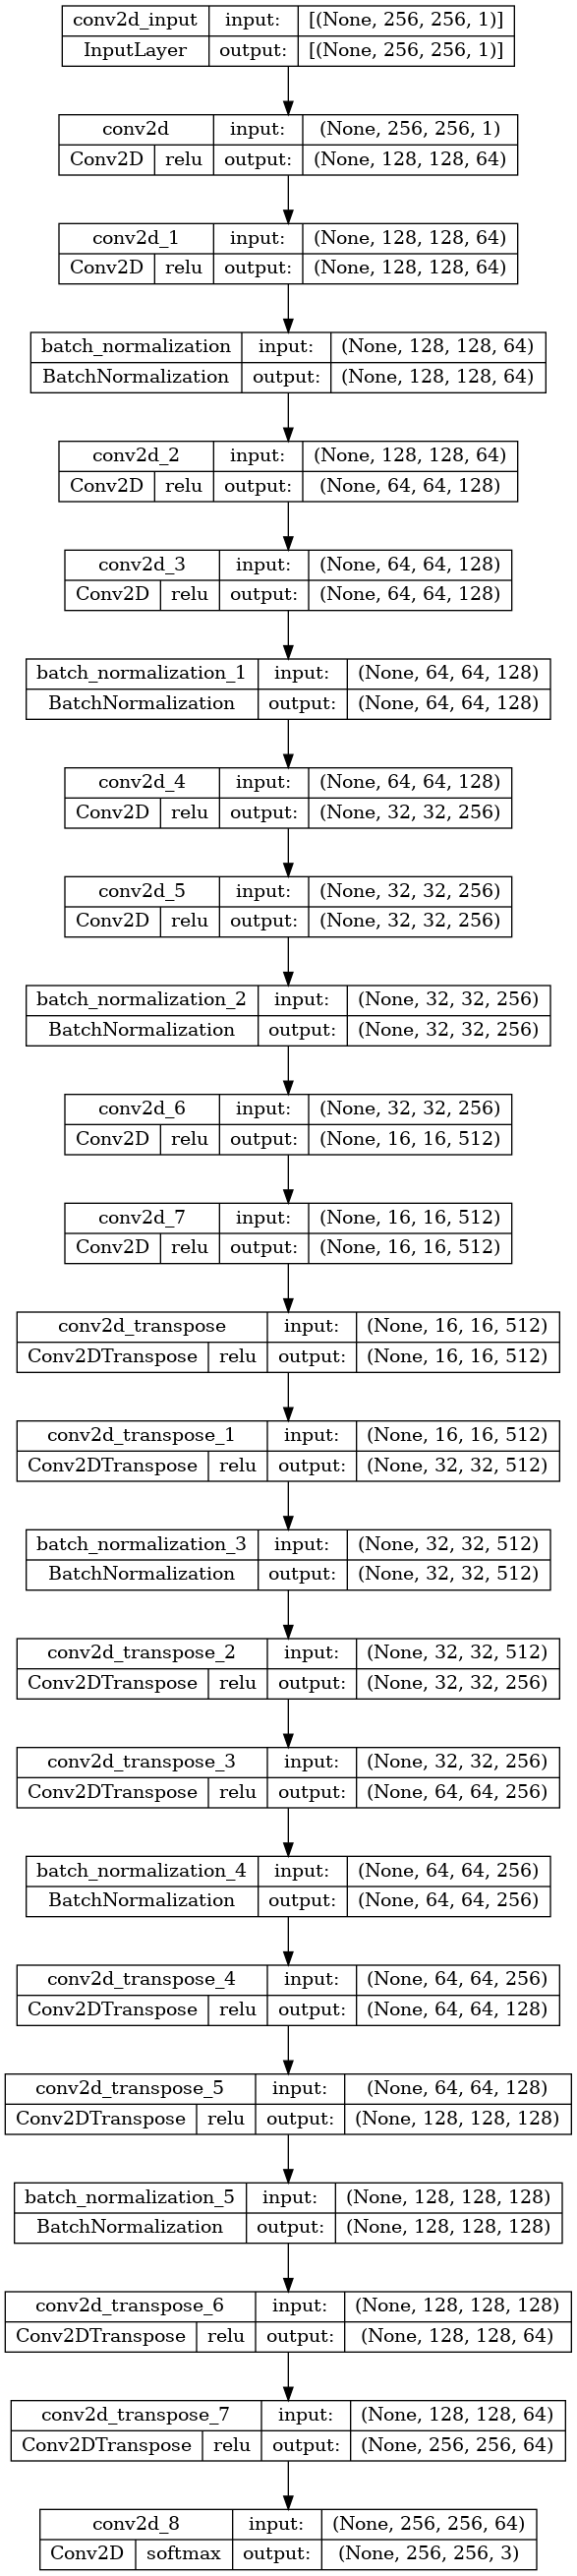

In [25]:
utils.plot_model(fcnn, show_shapes=True, show_layer_names=True, show_layer_activations=True, expand_nested=True)

In [26]:
fcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                       

In [40]:
fcnn.load_weights('../models/fcnn/fcnn_focal_normal_parte2_weights.keras')

In [50]:
fcnn.compile(
    optimizer=Adam(),
    loss=keras.losses.categorical_focal_crossentropy,
    metrics=metrics
)

In [ ]:
fcnn.fit(
    x=train_dataset,
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=100   
)

# Modello U-Net

U-Net è un modello di rete neurale convoluzionale che è stato sviluppato specificamente per l'analisi di immagini mediche. Questo modello ha dimostrato un'efficacia notevole nel task di segmentazione, che è l'identificazione e l'etichettatura di parti specifiche di un'immagine.

U-Net è composta da due parti principali: l'encoder e il decoder. L'encoder è responsabile dell'estrazione delle caratteristiche dell'immagine e il decoder utilizza queste caratteristiche per generare l'output finale. Il design particolare di U-Net, che include una struttura a forma di "U", consente al modello di apprendere una rappresentazione concisa delle informazioni all'interno dell'immagine.

Infine il modello U-Net utilizza una connessione "skip" tra le reti encoder e decoder. Questa connessione consente al modello di mantenere le informazioni dettagliate che sono state perse durante l'estrazione delle caratteristiche, permettendo così una segmentazione più precisa.

<br/>
<img src="../images/unet.jpg"/>

In [41]:
def get_unet_model(input_shape, num_classes):

    inputs = tf.keras.layers.Input(shape=input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [42]:
u_net = get_unet_model((256, 256, 1), 3)

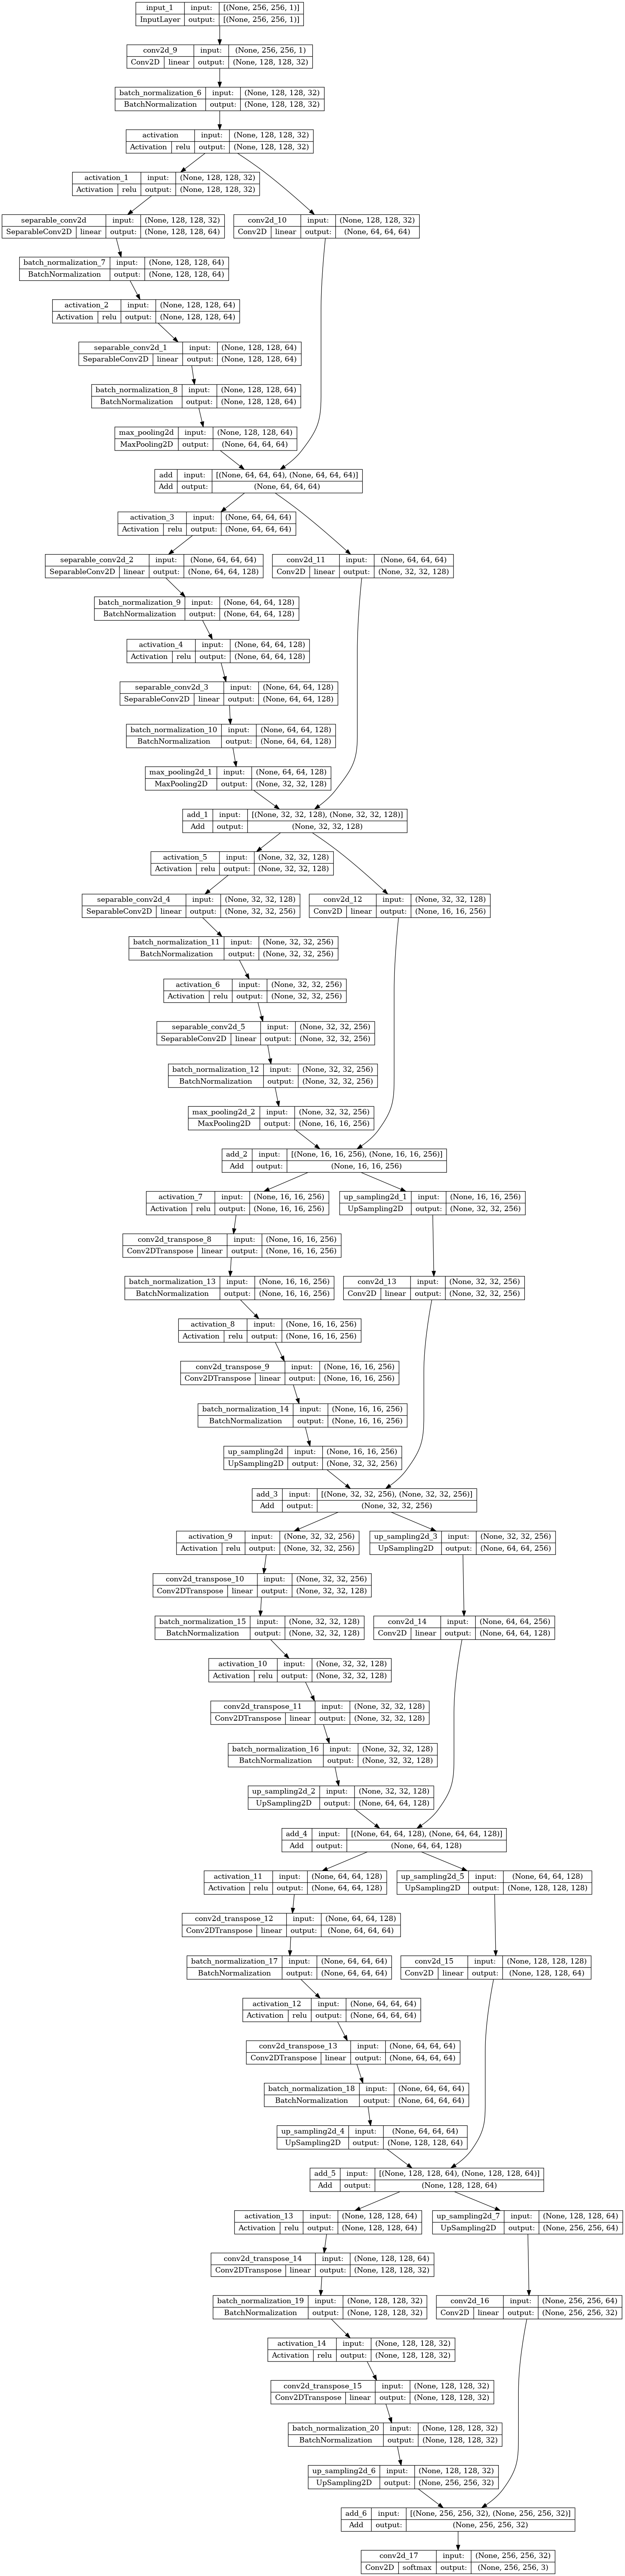

In [33]:
utils.plot_model(u_net, show_shapes=True, show_layer_names=True, show_layer_activations=True, expand_nested=True)

In [43]:
u_net.load_weights('../models/u-net/u-net_crs_normal_parte2_weights.keras')

In [51]:
u_net.compile(
    optimizer=Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=metrics,
    run_eagerly=True
)

In [ ]:
u_net.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Risultati ottenuti

In [37]:
test_dataset = Dataset.from_generator(
    lambda: image_generator('testing'),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
    )
)
test_dataset = test_dataset.batch(64)
fcnn_loss, *metrics_scores_fcnn = fcnn.evaluate(test_dataset)

2023-10-16 13:01:39.184366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-10-16 13:01:39.534818: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 13:01:41.529838: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


23/23 [==============================] - 36s 901ms/step - loss: 5.3805e-04 - categorical_accuracy: 0.9994 - f1_score_custom: 0.5626 - tp: 92409696.0000 - fp: 54345.0000 - tn: 184888272.0000 - fn: 61602.0000 - precision: 0.9994 - recall: 0.9993 - auc: 0.9999 - prc: 0.9998


2023-10-16 13:02:10.234105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9617490834407748153
2023-10-16 13:02:10.234144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10704845129142594714
2023-10-16 13:02:10.234152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5611906085931282587


In [38]:
test_dataset = Dataset.from_generator(
    lambda: image_generator('testing'),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
    )
)
test_dataset = test_dataset.batch(64)
u_net_loss, *metrics_scores_u_net = u_net.evaluate(test_dataset)

23/23 [==============================] - 20s 730ms/step - loss: 0.0029 - categorical_accuracy: 0.9993 - f1_score_custom: 0.5521 - tp: 184816640.0000 - fp: 109709.0000 - tn: 369775456.0000 - fn: 125929.0000 - precision: 0.9994 - recall: 0.9993 - auc: 0.9999 - prc: 0.9998


In [7]:
with open('../models/fcnn/fncc_focal_normal_parte3.pkl', 'rb') as file:
    history = pickle.load(file)

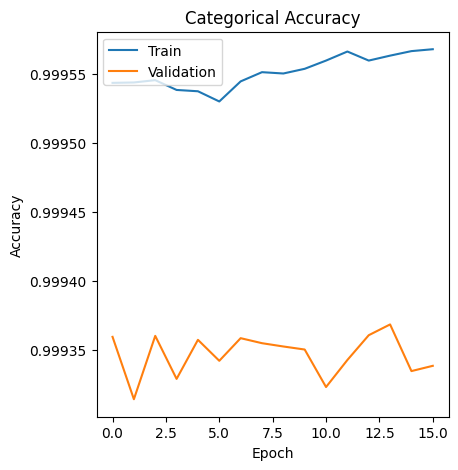

In [8]:
# Grafico per 'categorical_accuracy' e 'val_categorical_accuracy'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('Categorical Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Mostra i grafici
plt.show()

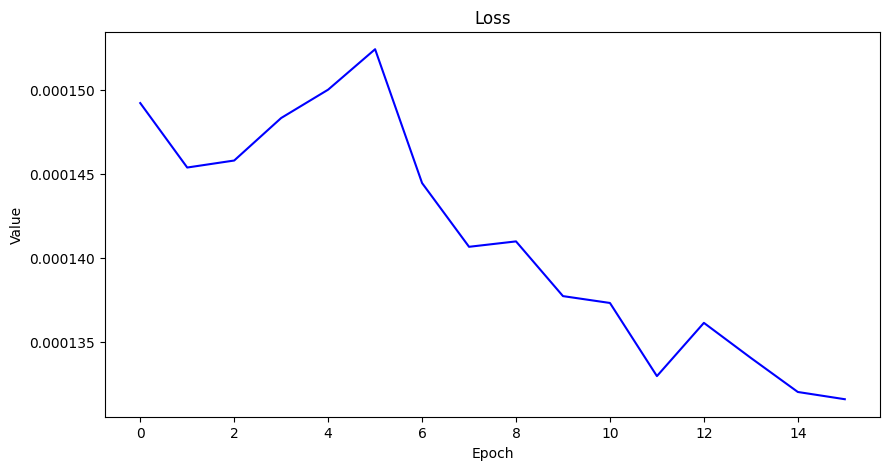

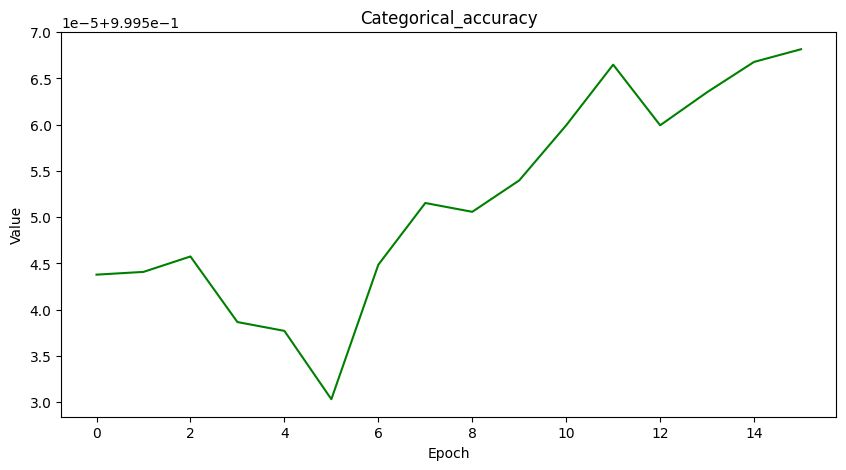

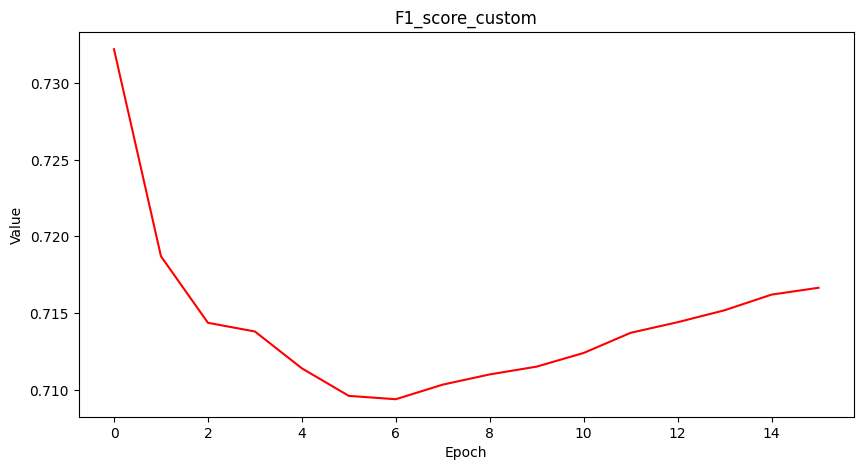

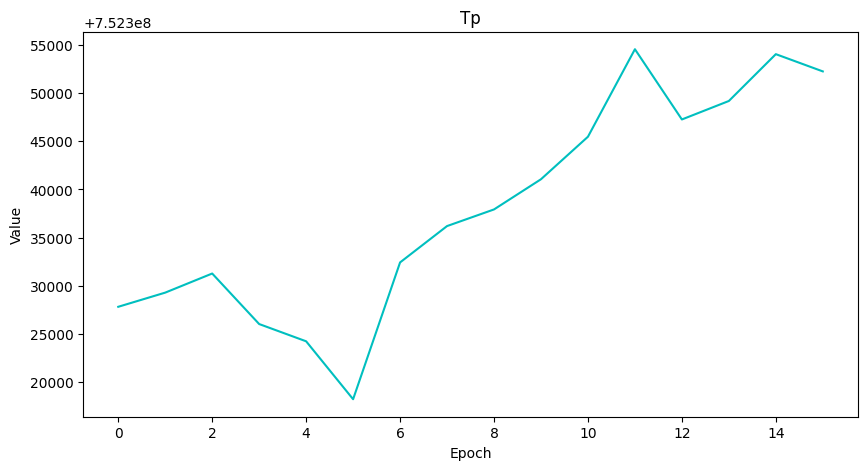

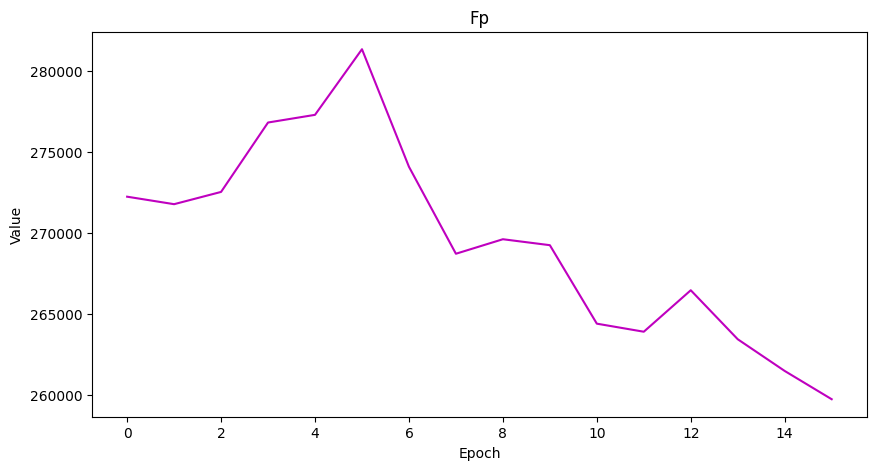

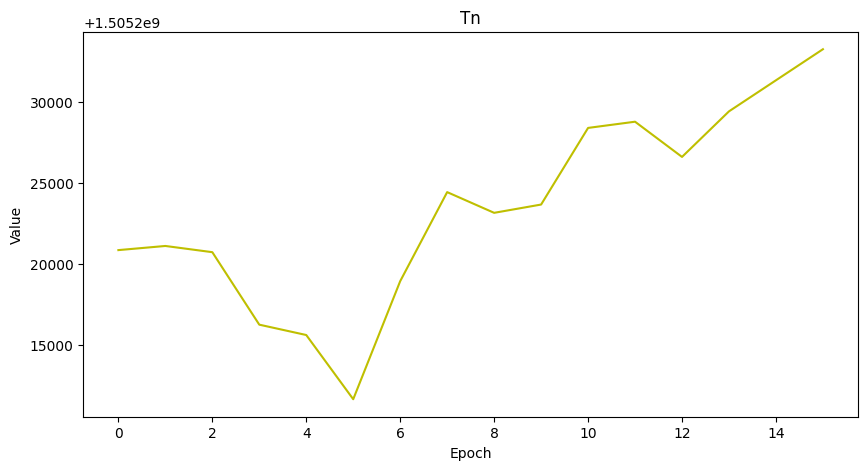

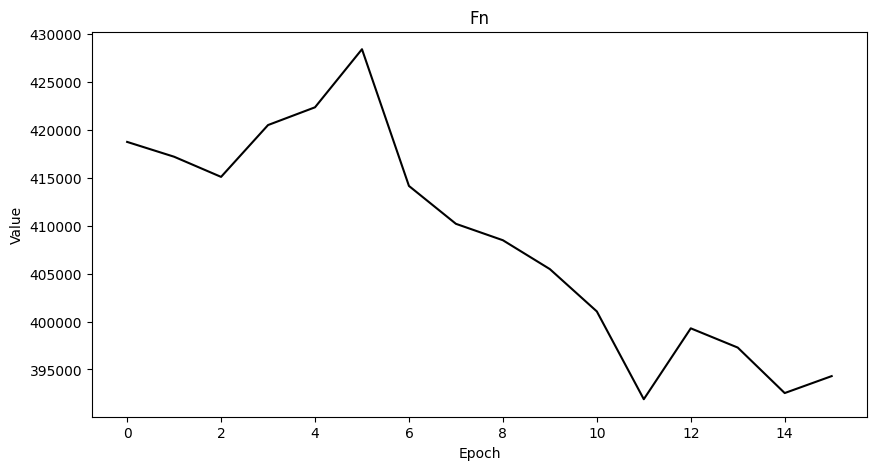

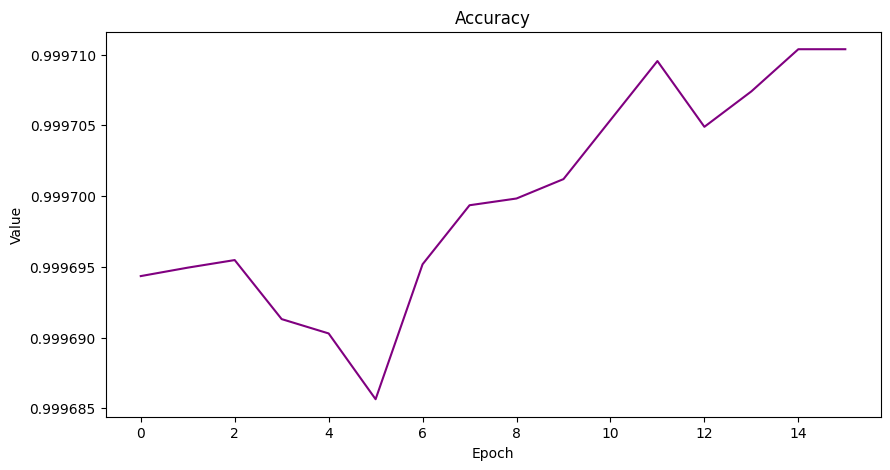

In [9]:
# Define a list of colors for each metric
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']

# Create a separate plot for each metric with a different color
for (key, metric), color in zip(history.items(), colors):
    plt.figure(figsize=(10, 5))
    plt.plot(metric, color=color)
    plt.title(f'{key.capitalize()}')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.show()

# Esempio di predizione

In [35]:
# Get a random image and mask from the testing set
input = next(iter(image_generator('testing')))

# Display original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input[0], cmap='gray')
plt.title('Original Image')

# Display ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(input[1], cmap='gray')
plt.title('Ground Truth Mask')

# Display overlay of image and mask
plt.subplot(1, 3, 3)
plt.imshow(input[0], cmap='gray')
plt.imshow(input[1], alpha=0.2)
plt.title('Image with Mask Overlay')

plt.tight_layout()
plt.show()

# Prepare input for models
input = np.expand_dims(input[0], 0)

# Get predictions from FCNN
out = fcnn(input)
out = np.squeeze(out)
out = np.argmax(out, axis=-1)

# Get predictions from U-Net
u_net_out = u_net(input)
u_net_out = np.squeeze(u_net_out)
u_net_out = np.argmax(u_net_out, axis=-1)

# Display FCNN prediction
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(input[0], cmap='gray')
plt.imshow(out, alpha=0.2)
plt.title('FCNN Prediction')

# Display U-Net prediction
plt.subplot(1, 2, 2)
plt.imshow(input[0], cmap='gray')
plt.imshow(u_net_out, alpha=0.2)
plt.title('U-Net Prediction')

plt.tight_layout()
plt.show()

NameError: name 'image_generator' is not defined

![Original Image](../images/output/out_rete.png)
![Prediction](../images/output/out_rete_2.png)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

TP, FN, FP, TN = history['tp'], history['fn'], history['fp'], history['tn']

# Crea la matrice di confusione come array NumPy
confusion_matrix = np.array([[TP, FN], [FP, TN]])

# Etichette per le righe e le colonne della matrice
labels = ["Positive", "Negative"]

# Crea un grafico a barre per la matrice di confusione
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice di Confusione")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Aggiungi testo alle celle
thresh = confusion_matrix.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="white" if confusion_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Classe Effettiva')
plt.xlabel('Classe Predetta')

# Mostra il grafico
plt.show()